In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [8]:
# Load CIFAR-10 dataset and preprocess the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


In [9]:
# Define the DenseNet model for fine-tuning
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the validation set for monitoring
batch_size = 128
epochs = 20
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
352/352 [==============================] - 310s 817ms/step - loss: 1.1922 - accuracy: 0.6094 - val_loss: 2.1115 - val_accuracy: 0.4378
Epoch 2/20
352/352 [==============================] - 277s 788ms/step - loss: 0.6937 - accuracy: 0.7852 - val_loss: 1.7870 - val_accuracy: 0.6366
Epoch 3/20
352/352 [==============================] - 277s 788ms/step - loss: 0.5498 - accuracy: 0.8273 - val_loss: 1.0501 - val_accuracy: 0.7214
Epoch 4/20
352/352 [==============================] - 275s 781ms/step - loss: 0.4683 - accuracy: 0.8544 - val_loss: 1.0483 - val_accuracy: 0.7034
Epoch 5/20
352/352 [==============================] - 265s 752ms/step - loss: 0.4029 - accuracy: 0.8755 - val_loss: 0.8691 - val_accuracy: 0.7552
Epoch 6/20
352/352 [==============================] - 243s 691ms/step - loss: 0.3464 - accuracy: 0.8939 - val_loss: 0.7932 - val_accuracy: 0.7754
Epoch 7/20
352/352 [==============================] - 245s 697ms/step - loss: 0.2949 - accuracy: 0.9087 - val_loss: 0.8728 -

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

79/79 [==============================] - 17s 189ms/step - loss: 1.0172 - accuracy: 0.8015
Test Loss: 1.0172477960586548
Test Accuracy: 0.8015000224113464


In [11]:
# plotting helper function
def plothist(hist):
    plt.rcParams["figure.figsize"] = (16, 8)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

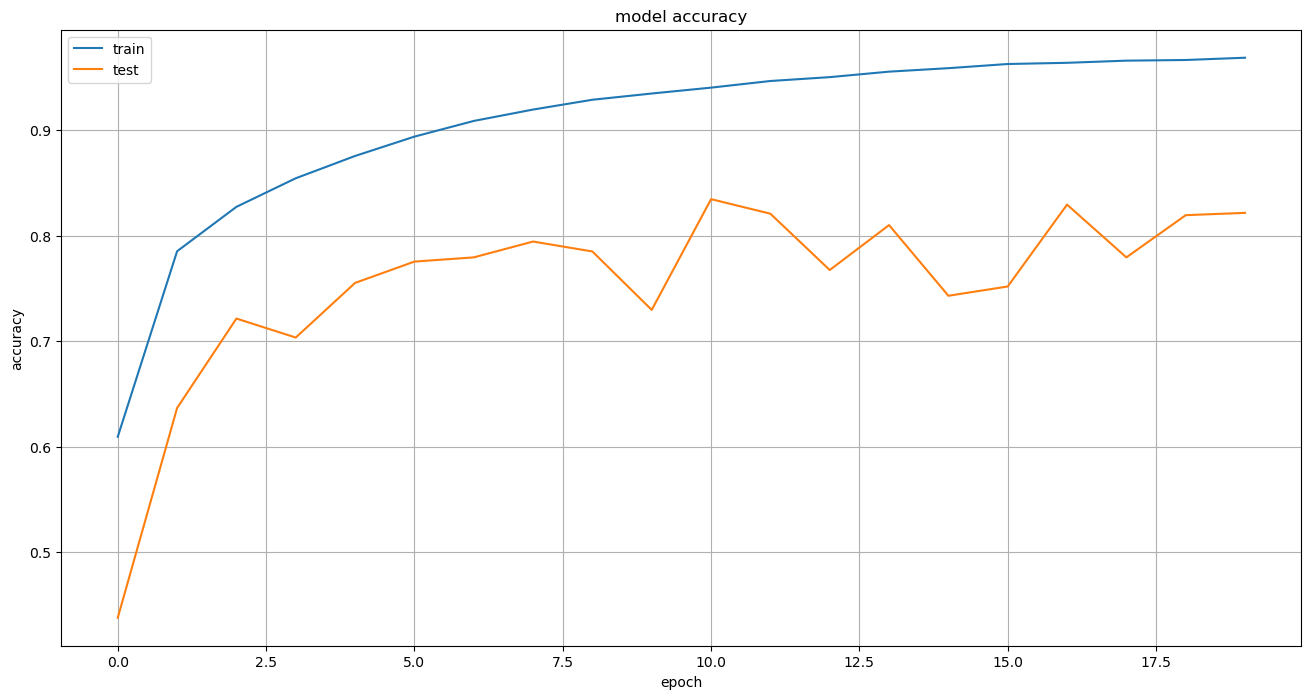

In [12]:
plothist(history)